In [1]:
import json
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from pycbc.types import timeseries
from calcwf import *
from interpolating_match import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# Directory of waveforms
waveform_dir = '/home/isobel.romero-shaw/public_html/PYCENTRICITY/pycentricity-plus-precession/ben_project/'

# Calculating harmonics

In [4]:
# Paths to harmonic basis
harmonic_basis_paths = [waveform_dir+f'harmonic_wf_{index}_thjn_0.000000.txt' for index in [10, *np.arange(9)]]

In [5]:
# Create pycbc timeseries of waveforms with initial data cut to enforce same size/same merger time
def load_comp_wfs():
    harmonic_basis = []
    harmonic_basis_raw = [np.loadtxt(path, delimiter=',') for path in harmonic_basis_paths]
    min_len = np.min([len(raw_wf) for raw_wf in harmonic_basis_raw])
    for raw_wf in harmonic_basis_raw:
        t = raw_wf[-min_len:,0]
        hp = raw_wf[-min_len:,1]
        hc = raw_wf[-min_len:,2]
        h = timeseries.TimeSeries(hp - 1j*hc, 1/round(1/np.mean(np.diff(t))), epoch=0)
        harmonic_basis.append(h)
    return harmonic_basis

In [7]:
# Get component waveforms for basis 
# Will use this function in edited get_h() to get harmonics
def gen_component_wfs_seobnrpe(f_low, e, M, q, n, sample_rate, approximant, normalisation, phase, f_match):

    # Make sure chosen parameters are those used to generate these component waveforms
    assert f_low == 10
    assert e == 0.073
    assert q == 2
    assert M == chirp2total(23.97979764, 2)
    assert n == 10
    assert sample_rate == 2048
    assert phase == 0
    
    # Load in all component waveforms
    comp_wfs = load_comp_wfs()

    # Taper all waveforms
    comp_wfs = [taper_wf(h) for h in comp_wfs]

    # Correct phase of all beyond first
    overlaps = [overlap_cplx_wfs(h, comp_wfs[0], f_low, f_match=f_match) for h in comp_wfs[1:]]
    phase_angles = -np.angle(overlaps)/2
    comp_wfs[1:] = [comp_wfs[i+1]*np.exp(2*1j*phase_angles[i]) for i in range(9)]

    # Normalise if requested
    if normalisation:

        # Get normalisation from first waveform
        h.resize(ceiltwo(len(h))) 
        psd = gen_psd(h, f_low)
        sigma_0 = sigma(h.real(), psd=psd, low_frequency_cutoff=f_match)

        # Normalise subsequent waveforms
        sigma_hs = [sigma(h.real(), psd=psd, low_frequency_cutoff=f_match) for h in comp_wfs]
        comp_wfs[1:] = [comp_wfs[i+1]*sigma_0/sigma_h[i] for i in range(9)]
        
    return comp_wfs

# Edited get_h() to call above component wf function
def get_h_seobnrpe(coeffs, f_low, e, M, q, sample_rate, approximant='SEOBNRPE', f_match=20, subsample_interpolation=True, 
                   GS_normalisation=True, comp_normalisation=False, comp_phase=0, return_ovlps=False):
    """
    Generates a overall h waveform, h_1,...h_n, and s_1,...,s_n.

    Parameters:
        coeffs: List containing coefficients of h_1,...,h_n.
        f_low: Starting frequency.
        e: Eccentricity.
        M: Total mass.
        q: Mass ratio.
        sample_rate: Sample rate of waveform.
        approximant: Approximant to use.
        f_match: Low frequency cutoff to use.
        subsample_interpolation: Whether to use subsample interpolation.
        GS_normalisation: Whether to perform Grant-Schmidt orthogonalisaton to ensure (hj|hm) = 0 for j!=m.
        comp_normalisation: Whether to normalise s_1,...,s_n components to ensure (sj|sj) is constant.
        comp_phase: Initial phase of s_1,...,s_n components.
        return_ovlps: Whether to return overlaps between all unorthogonalised harmonics.
        
    Returns:
        All waveform components and combinations: h, h1, ..., h_n, s_1, ..., s_n
    """

    # Other approximants are deprecated
    assert approximant == 'SEOBNRPE'

    # Gets (normalised) components which make up overall waveform
    component_wfs = gen_component_wfs_seobnrpe(f_low, e, M, q, len(coeffs), sample_rate, approximant, comp_normalisation, comp_phase, f_match)

    # Calculate overall waveform and components in time domain
    wfs, ovlps, ovlps_perp = get_h_TD(f_low, coeffs, component_wfs, GS_normalisation, f_match, return_ovlps=return_ovlps)

    if return_ovlps:
        return wfs, ovlps, ovlps_perp
    else:    
        return wfs

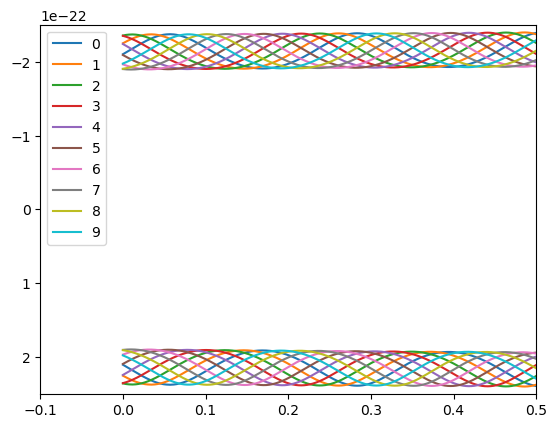

In [8]:
for i, wf in enumerate(load_comp_wfs()):
        # plt.plot(wf.sample_times, wf, c=f'C{i}')
        plt.plot(wf.sample_times, np.abs(wf), c=f'C{i}', label=i)
        plt.plot(wf.sample_times, -np.abs(wf), c=f'C{i}')
plt.ylim(0.25e-21, -0.25e-21)
plt.xlim(-0.1, 0.5)
plt.legend()

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


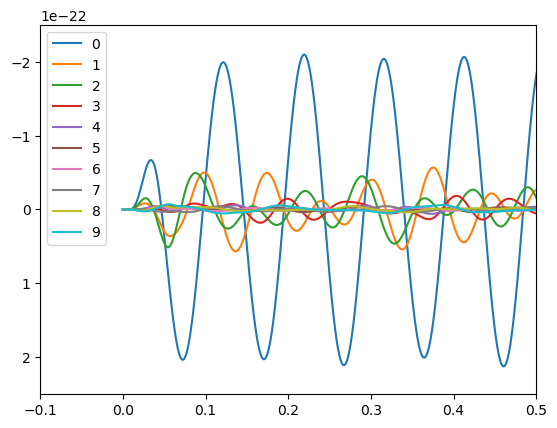

In [9]:
# Generate harmonics
all_wfs = get_h_seobnrpe([1]*10, 10, 0.073, chirp2total(23.97979764, 2), 2, 2048)
h_wfs = all_wfs[1:11]

# Plot harmonics
for i, wf in enumerate(h_wfs):
        plt.plot(wf.sample_times, wf, c=f'C{i}', label=i)
plt.ylim(0.25e-21, -0.25e-21)
plt.xlim(-0.1, 0.5)
plt.legend()

# Calculating matches

In [16]:
# Load json of trial waveforms
def load_trial_wfs(path):

    # Loads in with 'raw' formatting
    with open(path) as f:
        raw_wfs = json.load(f)

    return raw_wfs

In [17]:
# Calculate match with single trial waveform
def calc_single_match(harms, trial, psd, f_low, sample_rate):

    # Turn trial waveform into pycbc timeseries object
    trial = np.array(trial['plus']) - 1j*np.array(trial['cross'])
    trial = timeseries.TimeSeries(trial, 1/sample_rate, epoch=0)

    # Calculate matches
    match_cplx = match_hn(harms, trial, f_low, psd=psd)

    # Get match quantities
    match_quantities = []
    for i in range(1, len(harms)):
        match_quantities.append(np.abs(match_cplx[i])/np.abs(match_cplx[0])) # Single harmonic
        if i > 1:
            num = 0
            for j in range(1,i+1):
                num += np.abs(match_cplx[j])**2
            match_quantities.append(np.sqrt(num/np.abs(match_cplx[0]**2))) # Naive multiple harmonics
            if i == 2:
                pc_frac = comb_harm_consistent(np.abs(match_cplx[:i+1]), np.angle(match_cplx[:i+1]))
                match_quantities.append(pc_frac) # Phase consistent multiple harmonics

    # Save memory
    del trial

    return *match_cplx, np.linalg.norm(match_cplx), *match_quantities

# Calculate matches with all trial waveforms
def calc_raw_matches(harms, trials, fid_e, fid_chirp, q, n_gen, approximant, f_low=10, sample_rate=2048):

    # Create grid dictionary and calculate zero eccentricity chirp mass
    all_matches = {}
    zero_ecc_index = np.argmin(np.abs(trials['e0']))
    zero_ecc_chirp = trials['Mc0'][zero_ecc_index]

    # Calculate psd
    print('Calculating psd')
    all_lens = []
    for i in range(len(trials['wfs'])):
        all_lens.append([])
        for j in range(len(trials['wfs'][0])):
            all_lens[-1].append(len(trials['wfs'][i][j]['plus']))
    e_len = len(all_lens)
    MA_len = len(all_lens[0])
    max_ind_tot = np.argmax(np.array(all_lens).flatten())
    max_e_ind = int(max_ind_tot/MA_len)
    max_MA_ind = max_ind_tot%MA_len
    h_psd = np.array(trials['wfs'][max_e_ind][max_MA_ind]['plus']) - 1j*np.array(trials['wfs'][max_e_ind][max_MA_ind]['plus'])
    h_psd = timeseries.TimeSeries(h_psd, 1/sample_rate, epoch=0)
    psd = gen_psd(h_psd, f_low)

    # Calculate harmonic ordering
    harm_ids = [0,1]
    for i in range(2,len(harms)):
        if harm_ids[-1] > 0:
            harm_ids.append(-harm_ids[-1])
        else:
            harm_ids.append(-harm_ids[-1]+1)    

    # Calculate all matches
    print('Calculating all matches')
    match_arr = []
    for i in range(len(trials['wfs'])):
        for j in range(len(trials['wfs'][0])):
            match_arr.append(calc_single_match(harms, trials['wfs'][i][j], psd, f_low, sample_rate))
        print(f'\r{(i+1)*MA_len} out of {e_len*MA_len} done', end='')
    match_arr = np.array(match_arr)

    # Put match arrays into appropriate dictionary keys
    print('\nSaving matches')
    matches = {}
    for i in range(len(harms)):
        matches[f'h{harm_ids[i]}'] = np.abs(match_arr[:,i].reshape(-1, MA_len))
        matches[f'h{harm_ids[i]}_phase'] = np.angle(match_arr[:,i].reshape(-1, MA_len))
    matches['quad'] = match_arr[:,len(harms)].reshape(-1, MA_len)
    count = len(harms)+1
    for i in range(1,len(harms)):
        matches[f'h{harm_ids[i]}_h0'] = match_arr[:,count].reshape(-1, MA_len)
        count += 1
        if i > 1:
            str_combo = ''
            for j in range(1, i+1):
                str_combo += f'h{harm_ids[j]}_'
            matches[f'{str_combo}h0'] = match_arr[:,count].reshape(-1, MA_len)
            count += 1
            if i == 2:
                matches[f'{str_combo}h0_pc'] = match_arr[:,count].reshape(-1, MA_len)
                count += 1

    # Add parameter keys
    matches['fid_params'] = {}
    matches['fid_params']['f_low'] = f_low
    matches['fid_params']['e'] = fid_e
    matches['fid_params']['M'] = chirp2total(fid_chirp, q)
    matches['fid_params']['q'] = q
    matches['fid_params']['n'] = len(harms)
    matches['fid_params']['n_gen'] = n_gen
    matches['fid_params']['sample_rate'] = sample_rate
    matches['fid_params']['approximant'] = approximant

    # Other keys
    matches['e_vals'] = trials['e0']

    # Return appropriate dictionary
    all_matches[zero_ecc_chirp] = matches
    return all_matches

In [10]:
# raw_trial_wfs = load_trial_wfs(os.path.join(waveform_dir, 'trial_wfs_thjn_0.000000.json'))
# grid_0 = calc_raw_matches(h_wfs[:4], raw_trial_wfs, 0.073, 23.97979764, 2, len(h_wfs), 'SEOBRNPE', f_low=10, sample_rate=2048)
# with open(os.path.join('grid_data', 'dataslot_0', 'all_matches'), 'wb') as fp:
#         pickle.dump(grid_0, fp)
with open(os.path.join('grid_data', 'dataslot_0', 'all_matches'), 'rb') as fp:
        grid_data_0 = pickle.load(fp)

# Estimating eccentricity

First let's print out the min/max lines

In [11]:
# Find min and max
chirp = list(grid_data_0.keys())[0]
for key in list(grid_data_0[chirp].keys()):
    if key not in ['fid_params', 'e_vals', 'ovlps', 'ovlps_perp'] and 'phase' not in key:
        grid_data_0[chirp][f'{key}_max'] = np.nanmax(np.array(grid_data_0[chirp][key]), axis=1)
        grid_data_0[chirp][f'{key}_min'] = np.nanmin(np.array(grid_data_0[chirp][key]), axis=1)

In [ ]:
chirp = list(grid_data_0.keys())[0]

# Plot for each combination
plt.figure(figsize=(0.75*6.4, 0.75*4.8))
fid_e = chirp**(5/6)*0.035/(10**(5/6))
plt.axvline(fid_e, ls='dashed', c='C4', zorder=5/5, label='Fiducial $e_{10}$')
high_harm_min = np.sqrt(1-grid_data_0[chirp]['h0_max']**2)/grid_data_0[chirp]['h0_max']
high_harm_max = np.sqrt(1-grid_data_0[chirp]['h0_min']**2)/grid_data_0[chirp]['h0_min']
plt.plot(grid_data_0[chirp]['e_vals'], high_harm_max, c='k', zorder=4/5, label='$\\rho_{\\perp}$')
plt.plot(grid_data_0[chirp]['e_vals'], high_harm_min, c='k', zorder=4/5)
plt.fill_between(grid_data_0[chirp]['e_vals'], high_harm_min, high_harm_max, color='k', zorder=4/5, alpha=0.3)
plt.plot(grid_data_0[chirp]['e_vals'], grid_data_0[chirp]['h1_h0_max'], c='C0', zorder=2/5, label='$\\rho_1$')
plt.plot(grid_data_0[chirp]['e_vals'], grid_data_0[chirp]['h1_h0_min'], c='C0', zorder=2/5)
plt.fill_between(grid_data_0[chirp]['e_vals'], grid_data_0[chirp]['h1_h0_min'], 
                 grid_data_0[chirp]['h1_h0_max'], color='C0', zorder=2/5, alpha=0.3)
plt.plot(grid_data_0[chirp]['e_vals'], grid_data_0[chirp]['h-1_h0_max'], c='C1', zorder=1/5, label='$\\rho_{-1}$')
plt.plot(grid_data_0[chirp]['e_vals'], grid_data_0[chirp]['h-1_h0_min'], c='C1', zorder=1/5)
plt.fill_between(grid_data_0[chirp]['e_vals'], grid_data_0[chirp]['h-1_h0_min'], 
                 grid_data_0[chirp]['h-1_h0_max'], color='C1', zorder=1/5, alpha=0.3)
plt.plot(grid_data_0[chirp]['e_vals'], grid_data_0[chirp]['h1_h-1_h0_max'], c='C2', zorder=3/5, label='$\\sqrt{\\rho_1^2+\\rho_{-1}^2}$')
plt.plot(grid_data_0[chirp]['e_vals'], grid_data_0[chirp]['h1_h-1_h0_min'], c='C2', zorder=3/5)
plt.fill_between(grid_data_0[chirp]['e_vals'], grid_data_0[chirp]['h1_h-1_h0_min'], 
                 grid_data_0[chirp]['h1_h-1_h0_max'], color='C2', zorder=3/5, alpha=0.3)

plt.legend(frameon=False, loc=(0.25,0.53))
# plt.title(f'chirp={chirp:.4f}, fid_e={fid_e:.4f}')
plt.xlim(0,0.4)
plt.ylim(0,0.85)
plt.xlabel('$e_{10}$')
plt.ylabel('$\\rho_k$/$\\rho_0$')
plt.tight_layout()

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/axes/_axes.py:5398: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/axes/_axes.py:5399: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/axes/_axes.py:5402: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/axes/_axes.py:5404: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N+2:, 1] = dep2slice[::-1]


# Investigating shifting waveforms back

In [2]:
# Import pycentricity
import sys
pycentricity_dir = '/home/isobel.romero-shaw/public_html/PYCENTRICITY/pycentricity-plus-precession/ben_project/'
try:
    sys.path.index(pycentricity_dir)
except ValueError:
    sys.path.append(pycentricity_dir)
import pycentricity.waveform as pwf

In [3]:
def m1_m2_from_M_q(M, q):
    """
    Calculates component masses from total mass and mass ratio.

    Parameters:
        M: Total mass.
        q: Mass ratio.

    Returns:
        Masses of binary components.
    """
    
    m2 = M/(1+q)
    m1 = M - m2
    return m1, m2

def gen_seobnrpe_wf(f_low, e, M, q, a_1, a_2, sample_rate, phase, distance, thjn):
    m1, m2 = m1_m2_from_M_q(M, q)
    parameters = dict(
            mass_1 = m1,
            mass_2 = m2,
            luminosity_distance = distance,
            phase = phase,
            psi = 0,
            ra = 0,
            dec = 0,
            eccentricity = e,
            relativistic_anomaly = 0,
            theta_jn = thjn,
            a_1 = a_1,
            a_2 = a_2,
            phi_12 = np.pi,
            phi_jl = np.pi,
            tilt_1 = np.pi/2,
            tilt_2 = np.pi/2,
            geocent_time = 0

    )
    info = dict(
            reference_frequency=f_low,
            minimum_frequency=f_low,
            sampling_frequency=sample_rate,
            is_only22=True
    )
    hp, hc = pwf.generate_seobnrpe_waveform(parameters, info)
    seob_p = timeseries.TimeSeries(hp, 1/sample_rate, epoch=0)
    seob_c = timeseries.TimeSeries(hc, 1/sample_rate, epoch=0)
    return seob_p -1j*seob_c

Generating and plotting 10 basis waveforms with high precession

In [15]:
%%time

# Parameters
f_low = 10
e = 0.073
M = 60
q = 2
a_1 = 0.7
a_2 = 0.7

# Calculate frequency, eccentricity shifts
s_f_2pi = f_low - shifted_f(f_low, e, M, q)
s_fs = 10 - np.linspace(0, 1, 10, endpoint=False)*s_f_2pi
s_es = shifted_e(s_fs, f_low, e)

# Generates waveforms
harm_base_prec = []
for s_f, s_e in zip(s_fs, s_es):
    harm_base_prec.append(gen_seobnrpe_wf(s_f, s_e, M, q, a_1, a_2, 4096, 0, 500, 0))

# Aligns merger in time
min_len = np.min([len(wf) for wf in harm_base_prec])
for i in range(len(harm_base_prec)):
    harm_base_prec[i] = harm_base_prec[i][len(harm_base_prec[i])-min_len:]
    harm_base_prec[i].start_time = 0

CPU times: user 1min 18s, sys: 733 ms, total: 1min 18s
Wall time: 1min 19s


(-0.1, 0.5)

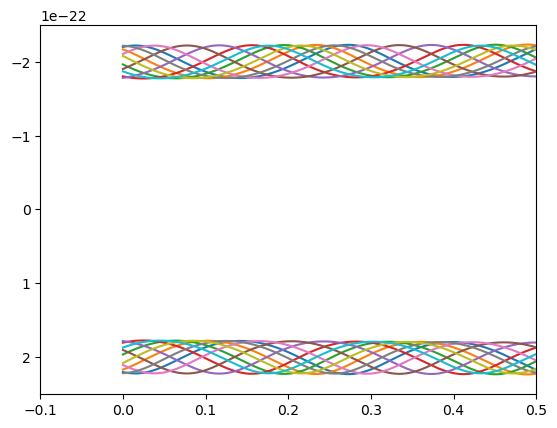

In [16]:
# Plot waveforms
for i, wf in enumerate(harm_base_prec):
        # plt.plot(wf.sample_times, wf, c=f'C{i}')
        plt.plot(wf.sample_times, np.abs(wf), c=f'C{i}')
        plt.plot(wf.sample_times, -np.abs(wf), c=f'C{i}')
plt.ylim(0.25e-21, -0.25e-21)
plt.xlim(-0.1, 0.5)

Generating and plotting 10 basis waveforms with zero precession

In [4]:
%%time

# Parameters
f_low = 10
e = 0.073
M = 60
q = 2
a_1 = 0.01
a_2 = 0

# Calculate frequency, eccentricity shifts
s_f_2pi = f_low - shifted_f(f_low, e, M, q)
s_fs = 10 - np.linspace(0, 1, 10, endpoint=False)*s_f_2pi
s_es = shifted_e(s_fs, f_low, e)

# Generates waveforms
harm_base_no_prec = []
for s_f, s_e in zip(s_fs, s_es):
    harm_base_no_prec.append(gen_seobnrpe_wf(s_f, s_e, M, q, a_1, a_2, 4096, 0, 500, 0))

# Aligns merger in time
min_len = np.min([len(wf) for wf in harm_base_no_prec])
for i in range(len(harm_base_no_prec)):
    harm_base_no_prec[i] = harm_base_no_prec[i][len(harm_base_no_prec[i])-min_len:]
    harm_base_no_prec[i].start_time = 0

CPU times: user 1min 14s, sys: 970 ms, total: 1min 15s
Wall time: 1min 16s


(-0.1, 0.5)

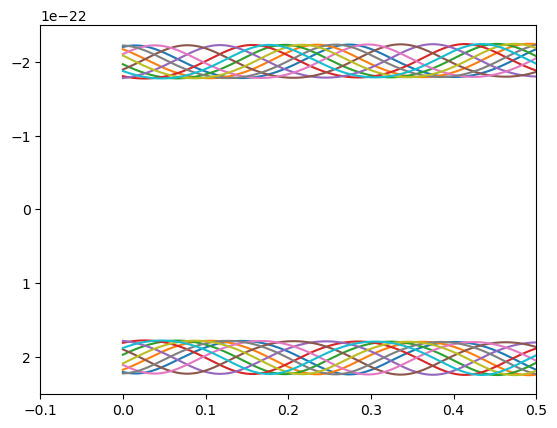

In [5]:
# Plot waveforms
for i, wf in enumerate(harm_base_no_prec):
        # plt.plot(wf.sample_times, wf, c=f'C{i}')
        plt.plot(wf.sample_times, np.abs(wf), c=f'C{i}')
        plt.plot(wf.sample_times, -np.abs(wf), c=f'C{i}')
plt.ylim(0.25e-21, -0.25e-21)
plt.xlim(-0.1, 0.5)